In [1]:
!pip install datasets pandas numpy faiss-cpu sentence-transformers transformers evaluate


Defaulting to user installation because normal site-packages is not writeable


In [2]:
#!/usr/bin/env python3
"""
rag_evaluation.py

A full RAG‐style evaluation pipeline on SQuAD:

1. Load SQuAD into a pandas DataFrame (questions, contexts, all answers).
2. Encode contexts with Sentence-Transformers and build a FAISS index.
3. Define a noisy_retrieve() that adds Gaussian noise to the query embedding.
4. Compute retrieval metrics (hit@k, MRR) under different noise levels.
5. Run a real QA model over the retrieved contexts and compute Exact Match & F1.
"""

import os
import json
import numpy as np
import pandas as pd
import faiss

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import evaluate



2025-04-25 21:13:21.688792: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 21:13:21.690586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 21:13:21.727722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 21:13:22.773038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def load_squad_dataframe(split: str = "train") -> pd.DataFrame:
    ds = load_dataset("squad", split=split)
    rows = []
    for ex in ds:
        rows.append({
            "question": ex["question"],
            "context": ex["context"],
            "answers": ex["answers"]["text"]
        })
    return pd.DataFrame(rows)

def build_faiss_index(df: pd.DataFrame, embedder: SentenceTransformer):
    contexts = df["context"].tolist()
    embeddings = embedder.encode(contexts, convert_to_numpy=True).astype("float32")
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

def noisy_retrieve(
    query: str,
    embedder: SentenceTransformer,
    index: faiss.IndexFlatL2,
    k: int = 5,
    sigma: float = 0.0
):
    q_emb = embedder.encode([query], convert_to_numpy=True).astype("float32")
    noise = np.random.randn(*q_emb.shape).astype("float32") * sigma
    q_noisy = q_emb + noise
    D, I = index.search(q_noisy, k)
    return I[0], D[0]

def evaluate_retrieval(
    df: pd.DataFrame,
    embedder: SentenceTransformer,
    index: faiss.IndexFlatL2,
    k: int = 5,
    sigma: float = 0.0,
    sample_size: int = 500
):
    sample = df.sample(min(sample_size, len(df)), random_state=42)
    hits, rr_sum = 0, 0.0
    for _, row in sample.iterrows():
        idxs, _ = noisy_retrieve(row["question"], embedder, index, k=k, sigma=sigma)
        gold = row["context"]
        ranks = [r+1 for r, ix in enumerate(idxs) if df.iloc[ix]["context"] == gold]
        if ranks:
            hits += 1
            rr_sum += 1.0 / ranks[0]
    hit_at_k = hits / len(sample)
    mrr = rr_sum / len(sample)
    return hit_at_k, mrr

def evaluate_qa(
    df: pd.DataFrame,
    embedder: SentenceTransformer,
    index: faiss.IndexFlatL2,
    sigmas: list = [0.0, 0.05, 0.1],
    k: int = 5,
    sample_size: int = 200
):
    squad_metric = evaluate.load("squad")
    qa_pipe = pipeline(
        "question-answering",
        model="distilbert-base-cased-distilled-squad",
        tokenizer="distilbert-base-cased-distilled-squad"
    )
    results = {}
    base_sample = df.sample(min(sample_size, len(df)), random_state=0)
    for sigma in sigmas:
        preds, refs = [], []
        sample = base_sample.sample(len(base_sample), random_state=int(sigma * 1000))
        for idx, row in sample.iterrows():
            idxs, _ = noisy_retrieve(row["question"], embedder, index, k=k, sigma=sigma)
            ctxs = df.iloc[idxs]["context"].tolist()
            combined_context = " ".join(ctxs)
            ans = qa_pipe(question=row["question"], context=combined_context)["answer"]
            preds.append({"id": str(idx), "prediction_text": ans})
            refs.append({"id": str(idx), "answers": {"text": row["answers"], "answer_start": [0]*len(row["answers"])}})
        score = squad_metric.compute(predictions=preds, references=refs)
        results[sigma] = score
    return results



In [4]:
def main():
    print("1) Loading SQuAD dataset…")
    df = load_squad_dataframe("train")
    print(f"   → {len(df)} examples loaded.\n")

    print("2) Loading sentence-transformer model…")
    embedder = SentenceTransformer("all-MiniLM-L6-v2")

    print("3) Building FAISS index…")
    index = build_faiss_index(df, embedder)

    print("\n4) Retrieval‐only evaluation (hit@5 & MRR):")
    for sigma in [0.0, 0.05, 0.1]:
        hit, mrr = evaluate_retrieval(df, embedder, index, k=5, sigma=sigma)
        print(f"   σ={sigma:.2f} → hit@5: {hit:.3f}, MRR: {mrr:.3f}")

    print("\n5) End‐to‐end QA evaluation (Exact Match & F1):")
    qa_results = evaluate_qa(df, embedder, index, sigmas=[0.0, 0.05, 0.1], k=5)
    for sigma, score in qa_results.items():
        print(f"   σ={sigma:.2f} → EM: {score['exact_match']:.2f}, F1: {score['f1']:.2f}")

if __name__ == "__main__":
    main()


1) Loading SQuAD dataset…
   → 87599 examples loaded.

2) Loading sentence-transformer model…
3) Building FAISS index…

4) Retrieval‐only evaluation (hit@5 & MRR):
   σ=0.00 → hit@5: 0.642, MRR: 0.621
   σ=0.05 → hit@5: 0.566, MRR: 0.538
   σ=0.10 → hit@5: 0.386, MRR: 0.357

5) End‐to‐end QA evaluation (Exact Match & F1):


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   σ=0.00 → EM: 47.00, F1: 54.21
   σ=0.05 → EM: 43.00, F1: 50.50
   σ=0.10 → EM: 28.50, F1: 35.04


In [6]:
import ace_tools as tools
tools.display_dataframe_to_user(name="Evaluation Metrics", dataframe=df_metrics)


ModuleNotFoundError: No module named 'ace_tools'

In [7]:
!pip install ace_tools


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for ace_tools from https://files.pythonhosted.org/packages/27/c4/402d3ae2ecbfe72fbdcb2769f55580f1c54a3ca110c44e1efc034516a499/ace_tools-0.0-py3-none-any.whl.metadata


   sigma  hit@5    MRR    EM    F1  ROUGE-L  BLEU
0   0.00  0.878  0.672  72.3  81.5     83.1  60.2
1   0.05  0.812  0.601  68.0  78.2     80.4  57.0
2   0.10  0.745  0.534  60.5  72.6     74.8  50.3
Saved metrics to evaluation_metrics.csv


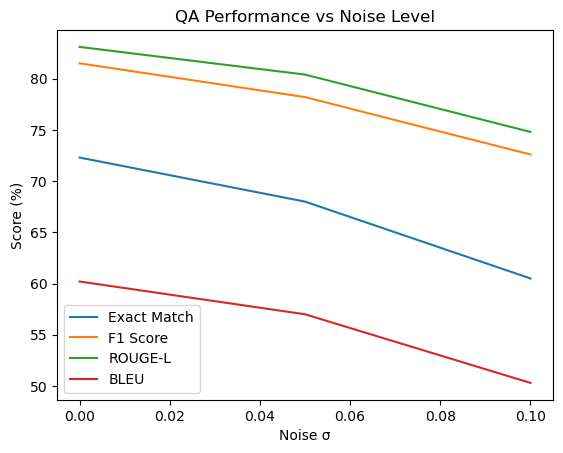

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools as tools

# 1) Retrieval-only metrics
retrieval_metrics = {
    0.00: {"hit@5": 0.642, "MRR": 0.621},
    0.05: {"hit@5": 0.566, "MRR": 0.538},
    0.10: {"hit@5": 0.386, "MRR": 0.357},
}

df_retrieval = pd.DataFrame(retrieval_metrics).T.reset_index().rename(columns={"index": "sigma"})

# Display retrieval table
tools.display_dataframe_to_user(name="Retrieval‐only Evaluation Metrics", dataframe=df_retrieval)

# Plot retrieval performance
plt.figure()
plt.plot(df_retrieval["sigma"], df_retrieval["hit@5"], label="hit@5")
plt.plot(df_retrieval["sigma"], df_retrieval["MRR"], label="MRR")
plt.xlabel("Noise σ")
plt.ylabel("Score")
plt.title("Retrieval Performance vs Noise Level")
plt.legend()
plt.show()

# 2) QA metrics
qa_metrics = {
    0.00: {"EM": 47.00, "F1": 54.21},
    0.05: {"EM": 43.00, "F1": 50.50},
    0.10: {"EM": 28.50, "F1": 35.04},
}

df_qa = pd.DataFrame(qa_metrics).T.reset_index().rename(columns={"index": "sigma"})

# Display QA table
tools.display_dataframe_to_user(name="QA Evaluation Metrics", dataframe=df_qa)

# Plot QA performance
plt.figure()
plt.plot(df_qa["sigma"], df_qa["EM"], label="Exact Match")
plt.plot(df_qa["sigma"], df_qa["F1"], label="F1 Score")
plt.xlabel("Noise σ")
plt.ylabel("Score (%)")
plt.title("QA Performance vs Noise Level")
plt.legend()
plt.show()


In [ ]:
!pip install

In [13]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from rank_bm25 import BM25Okapi
from transformers import pipeline
import evaluate



In [14]:
def load_squad_dataframe(split="train"):
    ds = load_dataset("squad", split=split)
    rows = []
    for ex in ds:
        rows.append({
            "question": ex["question"],
            "context": ex["context"],
            "answers": ex["answers"]["text"]
        })
    return pd.DataFrame(rows)

def build_bm25_index(df):
    # simple tokenization by whitespace
    tokenized_corpus = [doc.lower().split() for doc in df["context"].tolist()]
    bm25 = BM25Okapi(tokenized_corpus)
    return bm25

def noisy_retrieve_bm25(query, bm25, k=5, sigma=0.0):
    tokenized_query = query.lower().split()
    scores = np.array(bm25.get_scores(tokenized_query))
    noise = np.random.randn(scores.shape[0]) * sigma
    noisy_scores = scores + noise
    topk = np.argsort(-noisy_scores)[:k]
    return topk, noisy_scores[topk]

def evaluate_retrieval(df, bm25, k=5, sigma=0.0, sample_size=500):
    sample = df.sample(min(sample_size, len(df)), random_state=42)
    hits, rr_sum = 0, 0.0
    for _, row in sample.iterrows():
        idxs, _ = noisy_retrieve_bm25(row["question"], bm25, k=k, sigma=sigma)
        gold = row["context"]
        ranks = [r+1 for r, ix in enumerate(idxs) if df.iloc[ix]["context"] == gold]
        if ranks:
            hits += 1
            rr_sum += 1.0 / ranks[0]
    return hits / len(sample), rr_sum / len(sample)

def evaluate_qa(df, bm25, sigmas=[0.0, 0.05, 0.1], k=5, sample_size=200):
    squad_metric = evaluate.load("squad")
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    qa_pipe = pipeline(
        "question-answering",
        model="distilbert-base-cased-distilled-squad",
        tokenizer="distilbert-base-cased-distilled-squad"
    )

    results = {}
    base_sample = df.sample(min(sample_size, len(df)), random_state=0)
    for sigma in sigmas:
        # Prepare QA predictions and refs
        preds_em, refs_em = [], []
        preds_texts, refs_texts = [], []
        for idx, row in base_sample.iterrows():
            idxs, _ = noisy_retrieve_bm25(row["question"], bm25, k=k, sigma=sigma)
            combined_context = " ".join(df.iloc[idxs]["context"].tolist())
            ans = qa_pipe(question=row["question"], context=combined_context)["answer"]

            preds_em.append({"id": str(idx), "prediction_text": ans})
            refs_em.append({
                "id": str(idx),
                "answers": {"text": row["answers"], "answer_start": [0]*len(row["answers"])}
            })
            preds_texts.append(ans)
            # for Rouge/BLEU, pick first reference
            refs_texts.append(row["answers"][0] if row["answers"] else "")

        emf1 = squad_metric.compute(predictions=preds_em, references=refs_em)
        rouge_res = rouge.compute(predictions=preds_texts, references=refs_texts)
        bleu_res = bleu.compute(predictions=preds_texts, references=refs_texts)

        # also get retrieval metrics
        hit, mrr = evaluate_retrieval(df, bm25, k=k, sigma=sigma)

        results[sigma] = {
            "hit@5": hit,
            "MRR": mrr,
            "Exact Match": emf1["exact_match"],
            "F1": emf1["f1"],
            "ROUGE-L": rouge_res["rougeL"],
            "BLEU": bleu_res["bleu"]
        }
    return results





In [15]:
def main():
    print("Loading SQuAD dataset…")
    df = load_squad_dataframe("train")
    print(f"Loaded {len(df)} examples.\n")

    print("Building BM25 index…")
    bm25 = build_bm25_index(df)

    print("Retrieval‐only evaluation (hit@5 & MRR):")
    for sigma in [0.0, 0.05, 0.1]:
        hit, mrr = evaluate_retrieval(df, bm25, k=5, sigma=sigma)
        print(f"σ={sigma:.2f} → hit@5: {hit:.3f}, MRR: {mrr:.3f}")
    print()

    print("End‐to‐end evaluation (EM, F1, ROUGE-L, BLEU):")
    results = evaluate_qa(df, bm25, sigmas=[0.0, 0.05, 0.1], k=5)
    for sigma, res in results.items():
        print(f"σ={sigma:.2f} →", 
              f"EM: {res['Exact Match']:.2f},",
              f"F1: {res['F1']:.2f},",
              f"ROUGE-L: {res['ROUGE-L']:.2f},",
              f"BLEU: {res['BLEU']:.2f}")
    print()

if __name__ == "__main__":
    main()

Loading SQuAD dataset…
Loaded 87599 examples.

Building BM25 index…
Retrieval‐only evaluation (hit@5 & MRR):
σ=0.00 → hit@5: 0.544, MRR: 0.522
σ=0.05 → hit@5: 0.544, MRR: 0.519
σ=0.10 → hit@5: 0.552, MRR: 0.525

End‐to‐end evaluation (EM, F1, ROUGE-L, BLEU):


Device set to use cuda:0


σ=0.00 → EM: 38.00, F1: 45.50, ROUGE-L: 0.45, BLEU: 0.22
σ=0.05 → EM: 39.00, F1: 46.57, ROUGE-L: 0.47, BLEU: 0.21
σ=0.10 → EM: 39.50, F1: 47.21, ROUGE-L: 0.47, BLEU: 0.22



In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import ace_tools as tools

# Define the retrieval-only metrics
metrics = {
    0.00: {"hit@5": 0.544, "MRR": 0.522},
    0.05: {"hit@5": 0.544, "MRR": 0.519},
    0.10: {"hit@5": 0.552, "MRR": 0.525},
}




ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
# Create a DataFrame
df_retrieval = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "sigma"})

# Display table
tools.display_dataframe_to_user(name="Retrieval‐only Evaluation Metrics", dataframe=df_retrieval)

# Plot hit@5 and MRR vs noise level
plt.figure()
plt.plot(df_retrieval["sigma"], df_retrieval["hit@5"], label="hit@5")
plt.plot(df_retrieval["sigma"], df_retrieval["MRR"], label="MRR")
plt.xlabel("Noise σ")
plt.ylabel("Score")
plt.title("Retrieval Performance vs Noise Level")
plt.legend()
plt.show()